# LunarLander con DQN (Stable-Baselines3)

Este notebook entrena y evalúa un agente DQN de Stable-Baselines3 para el ambiente discreto `LunarLander-v3` de Gymnasium.

Resumen:
- Método: DQN de SB3 con red MLP, experiencia repetida, target updates y exploración epsilon.
- Ambiente: `LunarLander-v3` (acciones: 0=No-op, 1=Motor Izq., 2=Motor Principal, 3=Motor Der.).
- Objetivo: Aterrizar en la zona plana entre banderas (centro), robusto a variaciones del terreno.
- Mejor Puntaje: `264.27 ± 32.56` (evaluado en 500 episodios)
- Hardware: CPU, RAM 12 GB (uso aproximado ~2.5GB) (versión por defecto de Colab)
- Tiempo de entrenamiento: ~15 minutos
- Evita logs con `verbose = False`

Incluye entrenamiento con `EvalCallback` y checkpoints, evaluación con y sin vientos, para mayor robustez, y gráficos de aprendizaje y grabación de video.

## Instalación e importación de dependencias

Se incluye:
- `gymnasium`: Contiene la definición del ambiente LunarLander.
- `stable_baselines3`: Contiene el algorimo que utilizaremos para el problem: `DQN`
- Otras librerías auxiliares (computación numérica, ploteo, multimedia, I/O, etc.)

In [1]:
# Instalación de dependencias
# swig debe instalarse antes que box2d
%pip install -q swig
%pip install -q gymnasium[box2d] # instalar en una nueva línea para evitar errores en colab
%pip install -q stable-baselines3 matplotlib imageio imageio-ffmpeg
#%pip install -q tensorboard tqdm

from IPython.display import clear_output
clear_output()
print("Librerías instaladas correctamente.")

Librerías instaladas correctamente.


In [2]:
import sys, platform
import imageio
import gymnasium as gym
import numpy as np
import random
import os
import matplotlib.pyplot as plt
#from tqdm.auto import trange, tqdm
from IPython.display import Video, display

from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import ts2xy, load_results, plot_results

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

clear_output()
print('Usando Stable-Baselines3 DQN')

Usando Stable-Baselines3 DQN


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Definición del ambiente

In [3]:
# Definir el ambiente
def make_env(seed: int = SEED, render_mode=None, enable_wind: bool = False, **kwargs):
    env = gym.make('LunarLander-v3', render_mode=render_mode, enable_wind=enable_wind, **kwargs)
    env = Monitor(env) # para registrar las recompensas
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env

# Verificar espacios
_env = make_env()
clear_output()
print('Espacio de estados:', _env.observation_space.shape[0], ', Espacio de acciones:', _env.action_space.n)
_env.close()

Espacio de estados: 8 , Espacio de acciones: 4


In [4]:
# Utilidades SB3: callbacks de evaluación y checkpoints
log_dir = 'logs'
os.makedirs(log_dir, exist_ok=True)
eval_env = make_env(seed=SEED + 100, enable_wind=False)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=os.path.join(log_dir, 'best_model'),
    log_path=log_dir,
    eval_freq=10_000,
    deterministic=True,
    render=False,
    n_eval_episodes=10,
)

checkpoint_callback = CheckpointCallback(
    save_freq=50_000,
    save_path=os.path.join(log_dir, 'checkpoints'),
    name_prefix='dqn_lunar',
    save_replay_buffer=True,
    save_vecnormalize=False,
)

In [5]:
# Grabación de video opcional (SB3)
def record_video_sb3(model: DQN, filename: str = 'videos/lunar_dqn_episode.mp4', fps: int = 30, seed: int = SEED+999):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    env = make_env(seed=seed, render_mode='rgb_array')
    frames = []
    obs, info = env.reset(seed=seed)
    for _ in range(1000):
        frame = env.render()
        frames.append(frame)
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(int(action))
        if terminated or truncated:
            frame = env.render()
            frames.append(frame)
            break
    env.close()
    imageio.mimwrite(filename, frames, fps=fps, quality=8)
    print('Video guardado en:', filename)

## Definición del agente y Entrenamiento

- Algoritmo a utilizar: DQN, con policy MLP
- Justificación: El ambiente es sencillo y los entornos de Box2D requieren control basado en una simulación física simplificada, por ello DQN con policy MLP es una solución práctica y efectiva.

In [6]:
# Hiperparámetros de aprendizaje
TIMESTEPS = 350_000
POLICY_KWARGS = dict(net_arch=[256, 256])
LEARNING_RATE = 1e-3
GAMMA = 0.99
BUFFER_SIZE = 100_000
LEARNING_STARTS = 5_000
TRAIN_FREQ = 4
TARGET_UPDATE_INTERVAL = 1_000
TAU = 1.0
EXPLORATION_FRACTION = 0.35 # 0.5
EXPLORATION_FINAL_EPS = 0.05
BATCH_SIZE = 64

In [7]:
# Construir el modelo DQN de SB3
train_env = make_env(seed=SEED, enable_wind=False)
train_env = DummyVecEnv([lambda: Monitor(train_env, log_dir)])

model = DQN(
    policy='MlpPolicy',
    env=train_env,
    learning_rate=LEARNING_RATE,
    buffer_size=BUFFER_SIZE,
    learning_starts=LEARNING_STARTS,
    batch_size=BATCH_SIZE,
    gamma=GAMMA,
    train_freq=TRAIN_FREQ,
    target_update_interval=TARGET_UPDATE_INTERVAL,
    tau=TAU,
    exploration_fraction=EXPLORATION_FRACTION,
    exploration_final_eps=EXPLORATION_FINAL_EPS,
    policy_kwargs=POLICY_KWARGS,
    tensorboard_log=log_dir,
    verbose=0,
    seed=SEED,
)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Comportamiento antes del entrenamiento:

In [8]:
record_video_sb3(model, filename='videos/lunar_dqn_antes.mp4', fps=30)
display(Video('videos/lunar_dqn_antes.mp4', embed=True, width=500))

Video guardado en: videos/lunar_dqn_antes.mp4


In [9]:
# Entrenar con callbacks
model.learn(total_timesteps=TIMESTEPS, callback=[eval_callback, checkpoint_callback], progress_bar=True)

# Guardar el modelo final
os.makedirs('models', exist_ok=True)
model_path = 'models/dqn_lunarlander_sb3'
model.save(model_path)
print('Modelo guardado en', model_path)

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=10000, episode_reward=-135.32 +/- 21.25

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=20000, episode_reward=-86.99 +/- 29.11

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=30000, episode_reward=-71.91 +/- 20.11

Episode length: 870.20 +/- 260.34

New best mean reward!

Eval num_timesteps=40000, episode_reward=-160.28 +/- 50.12

Episode length: 415.50 +/- 201.82

Eval num_timesteps=50000, episode_reward=-148.40 +/- 38.99

Episode length: 335.50 +/- 158.03

Eval num_timesteps=60000, episode_reward=-156.50 +/- 40.35

Episode length: 515.40 +/- 180.23

Eval num_timesteps=70000, episode_reward=-138.56 +/- 22.09

Episode length: 329.70 +/- 56.45

Eval num_timesteps=80000, episode_reward=-141.56 +/- 84.05

Episode length: 848.00 +/- 201.82

Eval num_timesteps=90000, episode_reward=10.74 +/- 15.65

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=100000, episode_reward=-15.57 +/- 27.28

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=110000, episode_reward=-6.26 +/- 25.30

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=120000, episode_reward=-10.48 +/- 14.81

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=130000, episode_reward=-6.71 +/- 17.01

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=140000, episode_reward=-12.02 +/- 24.76

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=150000, episode_reward=9.70 +/- 45.01

Episode length: 995.80 +/- 12.60

Eval num_timesteps=160000, episode_reward=-128.26 +/- 20.94

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=170000, episode_reward=-16.16 +/- 32.06

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=180000, episode_reward=-38.00 +/- 30.29

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=190000, episode_reward=76.41 +/- 112.11

Episode length: 966.50 +/- 95.60

New best mean reward!

Eval num_timesteps=200000, episode_reward=268.83 +/- 16.44

Episode length: 279.60 +/- 71.86

New best mean reward!

Eval num_timesteps=210000, episode_reward=229.20 +/- 69.77

Episode length: 386.60 +/- 307.45

Eval num_timesteps=220000, episode_reward=82.95 +/- 100.66

Episode length: 167.80 +/- 51.14

Eval num_timesteps=230000, episode_reward=181.61 +/- 108.01

Episode length: 304.80 +/- 265.71

Eval num_timesteps=240000, episode_reward=128.49 +/- 107.33

Episode length: 159.40 +/- 59.15

Eval num_timesteps=250000, episode_reward=103.57 +/- 106.17

Episode length: 258.00 +/- 256.43

Eval num_timesteps=260000, episode_reward=107.84 +/- 128.30

Episode length: 629.00 +/- 333.54

Eval num_timesteps=270000, episode_reward=183.52 +/- 85.35

Episode length: 483.30 +/- 376.54

Eval num_timesteps=280000, episode_reward=155.40 +/- 115.27

Episode length: 139.10 +/- 25.94

Eval num_timesteps=290000, episode_reward=220.55 +/- 64.13

Episode length: 519.30 +/- 319.55

Eval num_timesteps=300000, episode_reward=262.58 +/- 21.88

Episode length: 307.50 +/- 129.42

Eval num_timesteps=310000, episode_reward=33.24 +/- 143.92

Episode length: 859.60 +/- 282.35

Eval num_timesteps=320000, episode_reward=176.12 +/- 89.08

Episode length: 687.00 +/- 338.89

Eval num_timesteps=330000, episode_reward=225.80 +/- 83.58

Episode length: 186.80 +/- 60.55

Eval num_timesteps=340000, episode_reward=215.84 +/- 71.56

Episode length: 447.90 +/- 367.52

Eval num_timesteps=350000, episode_reward=266.34 +/- 13.88

Episode length: 279.60 +/- 165.23

Modelo guardado en models/dqn_lunarlander_sb3


## Resultados del entrenamiento

In [10]:
# %load_ext tensorboard
# %tensorboard --logdir logs

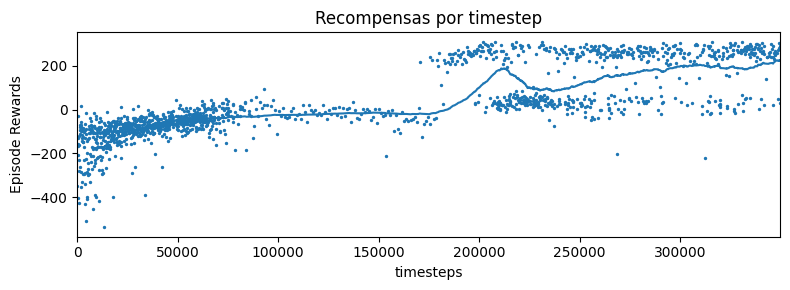

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [11]:
plot_results([log_dir], np.inf, 'timesteps', "Recompensas por timestep", figsize=(8,3))
plt.show()

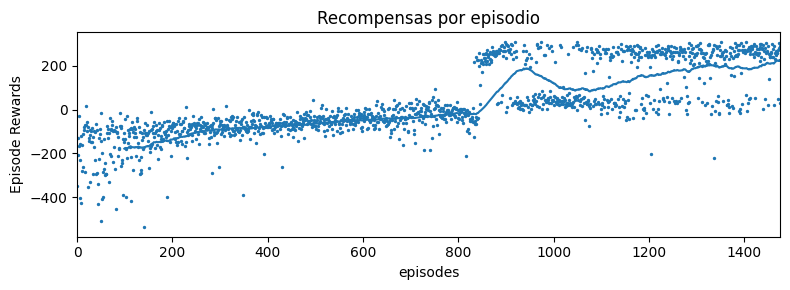

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [14]:
plot_results([log_dir], np.inf, 'episodes', "Recompensas por episodio", figsize=(8,3))
plt.show()

En ambos gráficos se puede observar que la cantidad de resultados con reward menor a 200 tiende a disminuir a medida que avanzamos en el entrenamiento ( la nube de puntos tiende a concentrarse por encima de `200` hacia el final).

In [15]:
# Cargar el mejor modelo (si existe) o usar el modelo recién entrenado
best_model_dir = os.path.join(log_dir, 'best_model')
best_model_path = os.path.join(best_model_dir, 'best_model.zip')

if os.path.exists(best_model_path):
    print('Cargando mejor modelo desde', best_model_path)
    best_model = DQN.load(best_model_path)
else:
    print('No hay mejor modelo aún; se usará el modelo actual')
    best_model = model

Cargando mejor modelo desde logs/best_model/best_model.zip


Comportamiento después del entrenamiento:

In [16]:
record_video_sb3(best_model, filename='videos/lunar_dqn_episode.mp4', fps=30)
display(Video('videos/lunar_dqn_episode.mp4', embed=True, width=500))

Video guardado en: videos/lunar_dqn_episode.mp4


## Evaluación

In [17]:
# Evaluación sin viento
N_EVAL_EPISODES=500
eval_env_no_wind = make_env(seed=SEED + 1000, enable_wind=False)
mean_reward, std_reward = evaluate_policy(best_model, eval_env_no_wind, n_eval_episodes=N_EVAL_EPISODES, deterministic=True)
print(f"Evaluación sin viento ({N_EVAL_EPISODES} eps): media={mean_reward:.2f} ± {std_reward:.2f}")

eval_env_no_wind.close()

Evaluación sin viento (500 eps): media=264.27 ± 32.56


In [18]:
# Evaluación con viento activado
eval_env_wind = make_env(seed=SEED + 2000, enable_wind=True, wind_power=10.0, turbulence_power=1.5)
mean_reward_wind, std_reward_wind = evaluate_policy(best_model, eval_env_wind, n_eval_episodes=N_EVAL_EPISODES, deterministic=True)
print(f"Evaluación con viento ({N_EVAL_EPISODES} eps): media={mean_reward_wind:.2f} ± {std_reward_wind:.2f}")

eval_env_wind.close()

Evaluación con viento (500 eps): media=198.04 ± 114.06


## Conclusiones

- DQN vanilla con CNN policy resultó ser suficiente para aterrizar exitosamente en la mayoría de simulaciones.
- Se observó un buen desempeño tanto en un ambiente sin viento, como en uno con viento activado.

## Referencias

- https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html
- https://stable-baselines.readthedocs.io/en/master/misc/results_plotter.html#stable_baselines.results_plotter.ts2xy